In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox

# Additional scklearn functions
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV   
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

# Classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
rcParams['figure.figsize'] = 12, 4


In [3]:
data = pd.read_csv("Training_Dataset.csv")

data.drop(['mvar1','mvar12'], axis=1, inplace=True)

data['card_extension'] = data['mvar46'] + 2*data['mvar47'] + 3*data['mvar48']
data.drop(['mvar46', 'mvar47', 'mvar48'], axis=1, inplace=True)

data['card_acceptance'] = data['mvar49'] + 2*data['mvar50'] + 3*data['mvar51']
data.drop(['mvar49', 'mvar50', 'mvar51'], axis=1, inplace=True)

In [4]:
y_extension = data['card_extension']
y_acceptance = data['card_acceptance']

In [5]:
def is_zero(s):
    return s < 1

var3 = data.pivot_table(values=["mvar3"], index=["mvar2","mvar4","mvar14",'card_extension',"mvar15"], aggfunc=np.mean)
var9 = data.pivot_table(values=["mvar9"], index=["mvar2","mvar4","mvar14",'card_extension',"mvar15"], aggfunc=np.mean)

for i,row in data.loc[is_zero(data['mvar3']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14'],row['card_extension']])
    data.loc[i,'mvar3'] = var3.loc[ind].values[0]
    
for i,row in data.loc[is_zero(data['mvar9']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14'],row['card_extension']])
    data.loc[i,'mvar9'] = var9.loc[ind].values[0]


In [6]:
def transformation_plot(var, log_multiply, cbrt_sum, boxcox_var):
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }
    print("feature : ",var.name)
    plt.figure(figsize=(12, 12))
    plt.subplot(411)
    plt.title('Without transformation')
    simple = var
    skness = skew(simple)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness),  fontdict=font)
    plt.hist(simple)


    plt.subplot(412) # equivalent to: plt.subplot(2, 2, 1)
    plt.title('Log transformation')
    log_var = np.log(log_multiply*var+1)
    skness_log = skew(log_var)
    plt.hist(log_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_log),  fontdict=font)

    plt.subplot(413)
    plt.title('cube root transformation')
    cbrt_var = np.cbrt(var+cbrt_sum)
    skness_cbrt = skew(cbrt_var)
    plt.hist(cbrt_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_cbrt),  fontdict=font)
    
    plt.subplot(414)
    plt.title('boxcox transformation')
    boxcox_var = boxcox(var+boxcox_var)[0]
    skness_boxcox = skew(boxcox_var)
    plt.hist(boxcox_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_boxcox),  fontdict=font)
    
def classifier_report(clf, X_train, y_train, X_test, y_test, predictors, n_classes=3, classes=[1,2,3],performCV=False, printFeatureImportance=True, cv_folds=2):
    
    #Fit classifies on traning dataset
    clf.fit(X_train[predictors], y_train)
    
    #Predict training and test set:
    dtrain_predictions = clf.predict(X_train[predictors])
    dtrain_predprob = clf.predict_proba(X_train[predictors])
    prediction = clf.predict(X_test[predictors])
    dtest_predprob = clf.predict_proba(X_test[predictors])
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(clf, X_train[predictors], y_train, cv=cv_folds)
    
    #Print model report:
    print ("\nModel Report")
    print ("Train Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print ("Test Accuracy : %.4g" % metrics.accuracy_score(y_test, prediction))
    '''
    y = label_binarize(y_train, classes=classes)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], dtrain_predprob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), dtrain_predprob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print("AUC Score (Train): %f" % roc_auc["micro"])  
    
    y1 = label_binarize(y_test, classes=classes)
    # Compute ROC curve and ROC area for each class
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y1[:, i], dtest_predprob[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute micro-average ROC curve and ROC area
    fpr1["micro"], tpr1["micro"], _ = roc_curve(y1.ravel(), dtest_predprob.ravel())
    roc_auc1["micro"] = auc(fpr1["micro"], tpr1["micro"])
    print("AUC Score (Test): %f" % roc_auc1["micro"])  
    '''
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    print(confusion_matrix(y_test, prediction))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    #http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [7]:
data_ext = data.copy()
data_ext.drop(['cm_key','card_extension','card_acceptance'], axis=1, inplace=True)
data_acc = data.copy()
data_acc.drop(['cm_key','card_extension','card_acceptance'], axis=1, inplace=True)

In [8]:
data_ext['mvar3'] = boxcox(data_ext['mvar3']+100)[0]
data_ext['mvar5'] = boxcox(data_ext['mvar5']+10)[0]
data_ext['mvar8'] = boxcox(data_ext['mvar8']+0.009)[0]
data_ext['mvar9'] = boxcox(data_ext['mvar9']+9)[0]
data_ext['mvar13'] = boxcox(data_ext['mvar13']+1.8)[0]
data_ext['mvar14'] = boxcox(data_ext['mvar14']+0.25)[0]
data_ext['mvar15'] = boxcox(data_ext['mvar15']+0.0000001)[0]
data_ext['mvar16'] = boxcox(data_ext['mvar16']+0.4)[0]
data_ext['mvar17'] = boxcox(data_ext['mvar17']+0.05)[0]
data_ext['mvar18'] = boxcox(data_ext['mvar18']+0.018)[0]
data_ext['mvar19'] = boxcox(data_ext['mvar19']+0.003)[0]
data_ext['mvar20'] = boxcox(data_ext['mvar20']+0.2)[0]
data_ext['mvar24'] = np.log(data_ext['mvar24']+1)
data_ext['mvar25'] = np.log(data_ext['mvar25']+1)
data_ext['mvar26'] = np.log(data_ext['mvar26']+1)
data_ext['mvar27'] = np.log(data_ext['mvar27']+1)
data_ext['mvar28'] = boxcox(data_ext['mvar28']+0.0000001)[0]
data_ext['mvar29'] = boxcox(data_ext['mvar29']+0.0000001)[0]
data_ext['mvar30'] = boxcox(data_ext['mvar30']+0.0000001)[0]
data_ext['mvar31'] = boxcox(data_ext['mvar31']+0.0000001)[0]
data_ext['mvar32'] = np.cbrt(data_ext['mvar32']-2)
data_ext['mvar33'] = np.cbrt(data_ext['mvar33']-2)
data_ext['mvar34'] = np.cbrt(data_ext['mvar34']-2)
data_ext['mvar35'] = np.cbrt(data_ext['mvar35']-2)
data_ext['mvar36'] = boxcox(data_ext['mvar36']+7)[0]
data_ext['mvar37'] = boxcox(data_ext['mvar37']+7)[0]
data_ext['mvar39'] = boxcox(data_ext['mvar39']+7)[0]
data_ext['mvar41'] = boxcox(data_ext['mvar41']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(data_ext)
ext_data = std_scale.transform(data_ext)
ext_data = pd.DataFrame(ext_data)
ext_data.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
                    'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
                    'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
                    'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
                    'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
                    'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [9]:
data_acc['mvar2'] = boxcox(data_acc['mvar2']+0.01)[0]
data_acc['mvar3'] = boxcox(data_acc['mvar3']+100)[0]
data_acc['mvar4'] = np.cbrt(data_acc['mvar4']+0.68)
data_acc['mvar6'] = np.cbrt(data_acc['mvar6']+14.5)
data_acc['mvar7'] = boxcox(data_acc['mvar7'])[0]
data_acc['mvar8'] = boxcox(data_acc['mvar8']+0.009)[0]
data_acc['mvar9'] = boxcox(data_acc['mvar9']+9)[0]
data_acc['mvar13'] = boxcox(data_acc['mvar13']+1.8)[0]
data_acc['mvar15'] = boxcox(data_acc['mvar15']+0.0000001)[0]
data_acc['mvar16'] = boxcox(data_acc['mvar16']+0.4)[0]
data_acc['mvar17'] = boxcox(data_acc['mvar17']+0.05)[0]
data_acc['mvar18'] = boxcox(data_acc['mvar18']+0.018)[0]
data_acc['mvar19'] = boxcox(data_acc['mvar19']+0.003)[0]
data_acc['mvar20'] = boxcox(data_acc['mvar20']+0.2)[0]
data_acc['mvar21'] = boxcox(data_acc['mvar21']+0.0000001)[0]
data_acc['mvar22'] = boxcox(data_acc['mvar22']+0.0000001)[0]
data_acc['mvar23'] = boxcox(data_acc['mvar23']+0.0000001)[0]
data_acc['mvar24'] = np.log(data_acc['mvar24']+1)
data_acc['mvar25'] = np.log(data_acc['mvar25']+1)
data_acc['mvar26'] = np.log(data_acc['mvar26']+1)
data_acc['mvar27'] = np.log(data_acc['mvar27']+1)
data_acc['mvar28'] = boxcox(data_acc['mvar28']+0.0000001)[0]
data_acc['mvar29'] = boxcox(data_acc['mvar29']+0.0000001)[0]
data_acc['mvar30'] = boxcox(data_acc['mvar30']+0.0000001)[0]
data_acc['mvar31'] = boxcox(data_acc['mvar31']+0.0000001)[0]
data_acc['mvar32'] = np.cbrt(data_acc['mvar32']-2)
data_acc['mvar33'] = np.cbrt(data_acc['mvar33']-2)
data_acc['mvar34'] = np.cbrt(data_acc['mvar34']-2)
data_acc['mvar35'] = np.cbrt(data_acc['mvar35']-2)
data_acc['mvar36'] = boxcox(data_acc['mvar36']+7)[0]
data_acc['mvar37'] = boxcox(data_acc['mvar37']+7)[0]
data_acc['mvar38'] = boxcox(data_acc['mvar38']+7)[0]
data_acc['mvar39'] = boxcox(data_acc['mvar39']+7)[0]
data_acc['mvar40'] = boxcox(data_acc['mvar40']+0.0000001)[0]
data_acc['mvar41'] = boxcox(data_acc['mvar41']+0.0000001)[0]
data_acc['mvar42'] = boxcox(data_acc['mvar42']+0.0000001)[0]
data_acc['mvar43'] = boxcox(data_acc['mvar43']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(data_acc)
acc_data = std_scale.transform(data_acc)
acc_data = pd.DataFrame(acc_data)
acc_data.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45',]

In [10]:
X1_train, X1_test,y_train_acceptance,y_test_acceptance,y_train_extension,y_test_extension = train_test_split(ext_data, y_acceptance, y_extension, test_size=0.20, random_state=659)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25).fit(ext_data)
X2_train = pca.transform(X1_train)
X2_test = pca.transform(X1_test)

X2_train = pd.DataFrame(X2_train)
X2_test = pd.DataFrame(X2_test)

X1_train.reset_index(drop=True, inplace=True)
X1_test.reset_index(drop=True, inplace=True)

X_ext_train = pd.concat([X1_train, X2_train], ignore_index=True, axis=1)
X_ext_test = pd.concat([X1_test, X2_test], ignore_index=True, axis=1)

print(X1_train.shape + X1_test.shape)
print(X2_train.shape + X2_test.shape)
print(X_ext_train.shape + X_ext_test.shape)

(32000, 43, 8000, 43)
(32000, 25, 8000, 25)
(32000, 68, 8000, 68)


In [ ]:
# ext classifier
from xgboost import XGBClassifier

ext_predictors = [x for x in X_ext_train.columns]

xgb_ext = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=1500, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=2, subsample=0.90, colsample_bytree=1,
                    scale_pos_weight=1)

#classifier_report(xgb_ext, X_ext_train, y_train_extension, X_ext_test, y_test_extension, ext_predictors)


xgb_ext.fit(X_ext_train,y_train_extension)

prediction = xgb_ext.predict(X_ext_test)

print(xgb_ext.score(X_ext_train,y_train_extension))

print(xgb_ext.score(X_ext_test,y_test_extension))

print(confusion_matrix(y_test_extension, prediction))

In [12]:
pca = PCA(n_components=25).fit(ext_data)

ext_data_pca = pca.transform(ext_data)

ext_data_pca = pd.DataFrame(ext_data_pca)

ext_data_pca.reset_index(drop=True, inplace=True)
ext_data.reset_index(drop=True, inplace=True)

ext_train = pd.concat([ext_data, ext_data_pca], ignore_index=True, axis=1)

ext_train.columns

RangeIndex(start=0, stop=68, step=1)

In [13]:
y_pred = xgb_ext.predict(ext_train)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['y_pres']

acc_data = pd.concat([acc_data, y_pred],axis=1)

In [14]:
acc_data.columns

Index(['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45',
       'y_pres'],
      dtype='object')

In [15]:
X3_train, X3_test,y_train_acceptance,y_test_acceptance,y_train_extension,y_test_extension = train_test_split(acc_data, y_acceptance, y_extension, test_size=0.20,stratify=y_acceptance, random_state=659)

In [16]:
X3_train = pd.concat([X3_train, y_train_extension], axis=1)
X3_train.drop('y_pres',axis=1,inplace=True)


In [17]:
X3_train.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45',
       'y_pres']

In [18]:
X3_test.columns

Index(['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45',
       'y_pres'],
      dtype='object')

In [19]:
pca = PCA(n_components=25).fit(acc_data)
X4_train = pca.transform(X3_train)
X4_test = pca.transform(X3_test)

X4_train = pd.DataFrame(X4_train)
X4_test = pd.DataFrame(X4_test)

X3_train.reset_index(drop=True, inplace=True)
X3_test.reset_index(drop=True, inplace=True)

X_acc_train = pd.concat([X3_train, X4_train], ignore_index=True, axis=1)
X_acc_test = pd.concat([X3_test, X4_test], ignore_index=True, axis=1)

print(X3_train.shape + X3_test.shape)
print(X4_train.shape + X4_test.shape)
print(X_acc_train.shape + X_acc_test.shape)

(32000, 44, 8000, 44)
(32000, 25, 8000, 25)
(32000, 69, 8000, 69)


In [20]:
from xgboost import XGBClassifier

predictors = [x for x in X_acc_test.columns]

In [21]:
unique, counts = np.unique(y_train_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

print("*********************")

unique, counts = np.unique(y_test_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

full confidence
[[    0 24897]
 [    1  2758]
 [    2  2123]
 [    3  2222]]
*********************
full confidence
[[   0 6225]
 [   1  689]
 [   2  531]
 [   3  555]]


In [22]:
unique, counts = np.unique(y_train_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

full confidence
[[    0 24897]
 [    1  2758]
 [    2  2123]
 [    3  2222]]


In [23]:
y_new_train_acceptance = y_train_acceptance.replace([1,2,3],[1,1,1])
unique, counts = np.unique(y_new_train_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

full confidence
[[    0 24897]
 [    1  7103]]


In [24]:
y_new_test_acceptance = y_test_acceptance.replace([1,2,3],[1,1,1])
unique, counts = np.unique(y_new_test_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

full confidence
[[   0 6225]
 [   1 1775]]


In [25]:
X_acc_train.drop([10,19,18,20,23,16,32,6,28,29,2,31,30,26,25,27,37,8,40,12,11], axis=1,inplace=True)

In [27]:
X_acc_train.drop([39,41,42,38], axis=1,inplace=True)

In [48]:
X_acc_test.drop([10,19,18,20,23,16,32,6,28,29,2,31,30,26,25,27,37,8,40,12,11,39,41,42,38], axis=1,inplace=True)

(17103, 44)

Model Report
Train Accuracy : 0.7901
Test Accuracy : 0.7601
[[5581  644]
 [1275  500]]


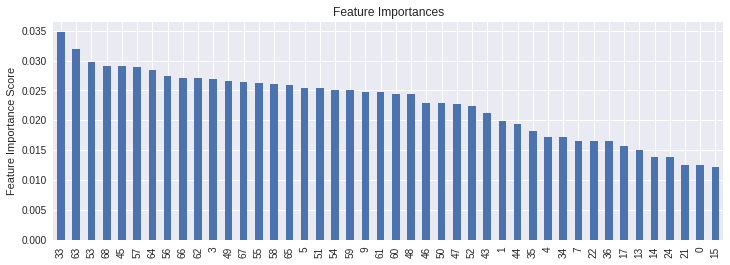

In [53]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero[:10000]
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)

train_predictors = [x for x in train.columns]


xgb_con = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=2000, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=1, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=0.65, seed = 55689)

classifier_report(xgb_con, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])

(20000, 44)

Model Report
Train Accuracy : 0.7756
Test Accuracy : 0.7765
[[5943  282]
 [1506  269]]


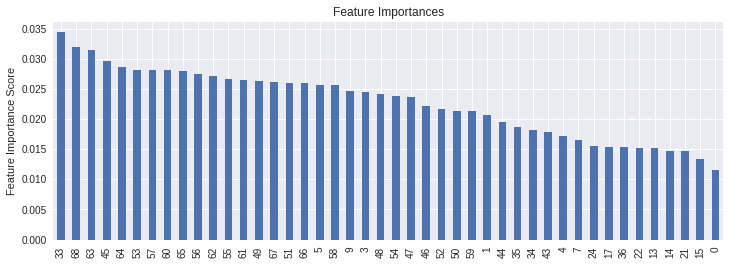

In [54]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero[12000:]
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)


xgb_con3 = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=1500, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=1, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=0.55, seed = 55689)

classifier_report(xgb_con3, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])



(21103, 44)

Model Report
Train Accuracy : 0.887
Test Accuracy : 0.7771
[[5864  361]
 [1422  353]]


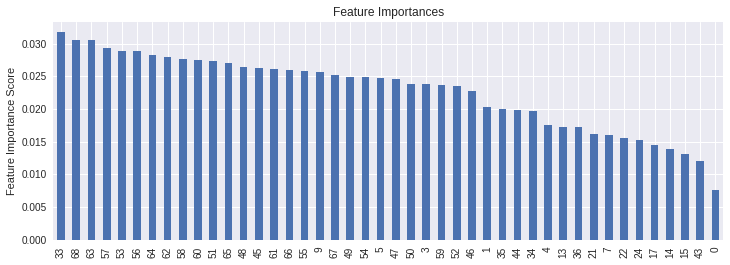

In [55]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero[8000:22000]
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)


xgb_con4 = XGBClassifier(max_depth=9, learning_rate=0.01, n_estimators=1000, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=3, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=0.70, seed = 55689)

classifier_report(xgb_con4, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])



(32000, 44)

Model Report
Train Accuracy : 0.8823
Test Accuracy : 0.7817
[[6068  157]
 [1589  186]]


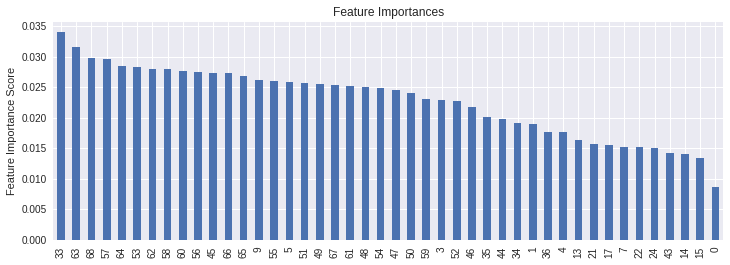

In [56]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)



xgb_con2 = XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=1500, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=6, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=1, seed = 55689)

classifier_report(xgb_con2, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])

In [57]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero[8000:22000]
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)

from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,100), activation='logistic', max_iter=20000, tol=0.00001)


classifier_report(mlp1, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])

(21103, 44)

Model Report
Train Accuracy : 0.7357
Test Accuracy : 0.7241
[[5130 1095]
 [1112  663]]


AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp2 = MLPClassifier(hidden_layer_sizes=(80,100,80,80,100,80), activation='relu', max_iter=20000, tol=0.00001)


classifier_report(mlp2, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])

In [374]:
prob1 = xgb_con.predict_proba(X_acc_test)
pred1 = prob1 > 0.44
pred1 = pd.DataFrame(pred1[:,1])
pred1 = 1*pred1
print(confusion_matrix(y_new_test_acceptance, pred1))
prob1 = pd.DataFrame(prob1[:,1])


[[5171 1054]
 [1059  716]]


In [383]:
prob2= xgb_con2.predict_proba(X_acc_test)
pred2 = prob2 > 0.30
pred2 = pd.DataFrame(pred2[:,1])
pred2 = 1*pred2
print(confusion_matrix(y_new_test_acceptance, pred2))
prob2 = pd.DataFrame(prob2[:,1])


[[5181 1044]
 [1034  741]]


In [376]:
prob3 = xgb_con3.predict_proba(X_acc_test)
pred3 = prob3 > 0.36
pred3 = pd.DataFrame(pred3[:,1])
pred3 = 1*pred3
print(confusion_matrix(y_new_test_acceptance, pred3))
prob3 = pd.DataFrame(prob3[:,1])


[[5296  929]
 [1128  647]]


In [390]:
prob4 = mlp1.predict_proba(X_acc_test)
pred4 = prob4 > 0.495
pred4 = pd.DataFrame(pred4[:,1])
pred4 = 1*pred4
print(confusion_matrix(y_new_test_acceptance, pred4))
prob4 = pd.DataFrame(prob4[:,1])


[[5101 1124]
 [1098  677]]


In [396]:
prob5 = xgb_con4.predict_proba(X_acc_test)
pred5 = prob5 > 0.34
pred5 = pd.DataFrame(pred5[:,1])
pred5 = 1*pred5
print(confusion_matrix(y_new_test_acceptance, pred5))
prob5 = pd.DataFrame(prob5[:,1])


[[4877 1348]
 [ 943  832]]


In [397]:
y_new_test_acceptance.reset_index(drop=True, inplace=True)
pred = pd.concat([y_new_test_acceptance,pred1,pred2,pred3,pred4,pred5,prob1,prob2,prob3,prob4,prob5], axis=1)
pred.columns = ['card_acceptance','pred1', 'pred2', 'pred3', 'pred4', 'pred5','prob1','prob2','prob3','prob4','prob5']

In [398]:
new = pred[pred['pred1']==1]
new1 = new[new['pred2']==1]
#new2 = new1[new1['pred3']==1]
new3 = new1[new1['pred4']==1]
new4 = new3[new3['pred5']==1]


In [399]:
new4.shape

(1017, 11)

In [400]:
new4[new4['card_acceptance']==1].shape

(473, 11)

In [211]:
new4['sum_prob'] = new4['prob1']+new4['prob2']+new4['prob3']+new4['prob4']
new4.sort_values('sum_prob', ascending=False).to_csv('pred1.csv')

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [330]:
haha = pd.read_csv("Leaderboard_Dataset.csv")

In [331]:
haha.drop(['mvar1','mvar12'], axis=1, inplace=True)

In [332]:
def is_zero(s):
    return s < 1

var3 = haha.pivot_table(values=["mvar3"], index=["mvar2","mvar4","mvar14","mvar15"], aggfunc=np.mean)
var9 = haha.pivot_table(values=["mvar9"], index=["mvar2","mvar4","mvar14","mvar15"], aggfunc=np.mean)

for i,row in haha.loc[is_zero(haha['mvar3']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14']])
    haha.loc[i,'mvar3'] = var3.loc[ind].values[0]
    
for i,row in haha.loc[is_zero(haha['mvar9']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14']])
    haha.loc[i,'mvar9'] = var9.loc[ind].values[0]

In [333]:
cm_key = haha['cm_key']
haha.drop('cm_key', axis=1, inplace=True)

In [334]:
haha_ext = haha.copy()
haha_acc = haha.copy()

In [335]:
haha_ext['mvar3'] = boxcox(haha_ext['mvar3']+100)[0]
haha_ext['mvar5'] = boxcox(haha_ext['mvar5']+10)[0]
haha_ext['mvar8'] = boxcox(haha_ext['mvar8']+0.009)[0]
haha_ext['mvar9'] = boxcox(haha_ext['mvar9']+9)[0]
haha_ext['mvar13'] = boxcox(haha_ext['mvar13']+1.8)[0]
haha_ext['mvar14'] = boxcox(haha_ext['mvar14']+0.25)[0]
haha_ext['mvar15'] = boxcox(haha_ext['mvar15']+0.0000001)[0]
haha_ext['mvar16'] = boxcox(haha_ext['mvar16']+0.4)[0]
haha_ext['mvar17'] = boxcox(haha_ext['mvar17']+0.05)[0]
haha_ext['mvar18'] = boxcox(haha_ext['mvar18']+0.018)[0]
haha_ext['mvar19'] = boxcox(haha_ext['mvar19']+0.003)[0]
haha_ext['mvar20'] = boxcox(haha_ext['mvar20']+0.2)[0]
haha_ext['mvar24'] = np.log(haha_ext['mvar24']+1)
haha_ext['mvar25'] = np.log(haha_ext['mvar25']+1)
haha_ext['mvar26'] = np.log(haha_ext['mvar26']+1)
haha_ext['mvar27'] = np.log(haha_ext['mvar27']+1)
haha_ext['mvar28'] = boxcox(haha_ext['mvar28']+0.0000001)[0]
haha_ext['mvar29'] = boxcox(haha_ext['mvar29']+0.0000001)[0]
haha_ext['mvar30'] = boxcox(haha_ext['mvar30']+0.0000001)[0]
haha_ext['mvar31'] = boxcox(haha_ext['mvar31']+0.0000001)[0]
haha_ext['mvar32'] = np.cbrt(haha_ext['mvar32']-2)
haha_ext['mvar33'] = np.cbrt(haha_ext['mvar33']-2)
haha_ext['mvar34'] = np.cbrt(haha_ext['mvar34']-2)
haha_ext['mvar35'] = np.cbrt(haha_ext['mvar35']-2)
haha_ext['mvar36'] = boxcox(haha_ext['mvar36']+7)[0]
haha_ext['mvar37'] = boxcox(haha_ext['mvar37']+7)[0]
haha_ext['mvar39'] = boxcox(haha_ext['mvar39']+7)[0]
haha_ext['mvar41'] = boxcox(haha_ext['mvar41']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(haha_ext)
ext_haha = std_scale.transform(haha_ext)
ext_haha = pd.DataFrame(ext_haha)
ext_haha.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9','mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17','mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24','mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31','mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38','mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [336]:
haha_acc['mvar2'] = boxcox(haha_acc['mvar2']+0.01)[0]
haha_acc['mvar3'] = boxcox(haha_acc['mvar3']+100)[0]
haha_acc['mvar4'] = np.cbrt(haha_acc['mvar4']+0.68)
haha_acc['mvar6'] = np.cbrt(haha_acc['mvar6']+14.5)
haha_acc['mvar7'] = boxcox(haha_acc['mvar7'])[0]
haha_acc['mvar8'] = boxcox(haha_acc['mvar8']+0.009)[0]
haha_acc['mvar9'] = boxcox(haha_acc['mvar9']+9)[0]
haha_acc['mvar13'] = boxcox(haha_acc['mvar13']+1.8)[0]
haha_acc['mvar15'] = boxcox(haha_acc['mvar15']+0.0000001)[0]
haha_acc['mvar16'] = boxcox(haha_acc['mvar16']+0.4)[0]
haha_acc['mvar17'] = boxcox(haha_acc['mvar17']+0.05)[0]
haha_acc['mvar18'] = boxcox(haha_acc['mvar18']+0.018)[0]
haha_acc['mvar19'] = boxcox(haha_acc['mvar19']+0.003)[0]
haha_acc['mvar20'] = boxcox(haha_acc['mvar20']+0.2)[0]
haha_acc['mvar21'] = boxcox(haha_acc['mvar21']+0.0000001)[0]
haha_acc['mvar22'] = boxcox(haha_acc['mvar22']+0.0000001)[0]
haha_acc['mvar23'] = boxcox(haha_acc['mvar23']+0.0000001)[0]
haha_acc['mvar24'] = np.log(haha_acc['mvar24']+1)
haha_acc['mvar25'] = np.log(haha_acc['mvar25']+1)
haha_acc['mvar26'] = np.log(haha_acc['mvar26']+1)
haha_acc['mvar27'] = np.log(haha_acc['mvar27']+1)
haha_acc['mvar28'] = boxcox(haha_acc['mvar28']+0.0000001)[0]
haha_acc['mvar29'] = boxcox(haha_acc['mvar29']+0.0000001)[0]
haha_acc['mvar30'] = boxcox(haha_acc['mvar30']+0.0000001)[0]
haha_acc['mvar31'] = boxcox(haha_acc['mvar31']+0.0000001)[0]
haha_acc['mvar32'] = np.cbrt(haha_acc['mvar32']-2)
haha_acc['mvar33'] = np.cbrt(haha_acc['mvar33']-2)
haha_acc['mvar34'] = np.cbrt(haha_acc['mvar34']-2)
haha_acc['mvar35'] = np.cbrt(haha_acc['mvar35']-2)
haha_acc['mvar36'] = boxcox(haha_acc['mvar36']+7)[0]
haha_acc['mvar37'] = boxcox(haha_acc['mvar37']+7)[0]
haha_acc['mvar38'] = boxcox(haha_acc['mvar38']+7)[0]
haha_acc['mvar39'] = boxcox(haha_acc['mvar39']+7)[0]
haha_acc['mvar40'] = boxcox(haha_acc['mvar40']+0.0000001)[0]
haha_acc['mvar41'] = boxcox(haha_acc['mvar41']+0.0000001)[0]
haha_acc['mvar42'] = boxcox(haha_acc['mvar42']+0.0000001)[0]
haha_acc['mvar43'] = boxcox(haha_acc['mvar43']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(haha_acc)
acc_haha = std_scale.transform(haha_acc)
acc_haha = pd.DataFrame(acc_haha)
acc_haha.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9','mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17','mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24','mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31','mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38','mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [337]:
pca = PCA(n_components=25).fit(ext_data)
ext_haha1 = pca.transform(ext_haha)

ext_haha1 = pd.DataFrame(ext_haha1)

ext_haha1.reset_index(drop=True, inplace=True)

leaderboard_ext = pd.concat([ext_haha, ext_haha1], ignore_index=True, axis=1)

print(leaderboard_ext.shape)

(10000, 68)


In [338]:
y_pred = xgb_ext.predict(leaderboard_ext)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['y_pres']

acc_haha = pd.concat([acc_haha, y_pred],axis=1)

In [339]:

pca = PCA(n_components=25).fit(acc_data)
acc_haha1 = pca.transform(acc_haha)

acc_haha1 = pd.DataFrame(acc_haha1)

acc_haha1.reset_index(drop=True, inplace=True)

leaderboard_acc = pd.concat([acc_haha, acc_haha1], ignore_index=True, axis=1)

print(leaderboard_acc.shape)

(10000, 69)


In [340]:
leaderboard_acc.drop([10,19,18,20,23,16,32,6,28,29,2,31,30,26,25,27,37,8,40,12,11,39,41,42,38], axis=1,inplace=True)

In [341]:
prob1 = xgb_con.predict_proba(leaderboard_acc)
pred1 = prob1 > 0.44
pred1 = pd.DataFrame(pred1[:,1])
pred1 = 1*pred1
prob1 = pd.DataFrame(prob1[:,1])

prob2= xgb_con2.predict_proba(leaderboard_acc)
pred2 = prob2 > 0.30
pred2 = pd.DataFrame(pred2[:,1])
pred2 = 1*pred2
prob2 = pd.DataFrame(prob2[:,1])

prob4 = mlp1.predict_proba(leaderboard_acc)
pred4 = prob4 > 0.495
pred4 = pd.DataFrame(pred4[:,1])
pred4 = 1*pred4
prob4 = pd.DataFrame(prob4[:,1])

prob5 = xgb_con4.predict_proba(leaderboard_acc)
pred5 = prob5 > 0.34
pred5 = pd.DataFrame(pred5[:,1])
pred5 = 1*pred5
prob5 = pd.DataFrame(prob5[:,1])

In [342]:
pred = pd.concat([cm_key,pred1,pred2,pred4,pred5,prob1,prob2,prob4,prob5], axis=1)
pred.columns = ['cm_key','pred1','pred2','pred4','pred5','prob1','prob2','prob4','prob5']

In [343]:
new = pred[pred['pred1']==1]
new1 = new[new['pred2']==1]
#new2 = new1[new1['pred3']==1]
new2 = new1[new1['pred4']==1]
new3 = new2[new2['pred5']==1]



In [344]:
new3['sum_prob'] = new3['prob1']+new3['prob2']+new3['prob4']+new3['prob5']
new3.sort_values('sum_prob', ascending=False)

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,cm_key,pred1,pred2,pred4,pred5,prob1,prob2,prob4,prob5,sum_prob
9688,59689,1,1,1,1,0.826803,0.865827,0.849070,0.877714,3.419415
8930,58931,1,1,1,1,0.858271,0.857030,0.850609,0.841714,3.407624
4,50005,1,1,1,1,0.901563,0.790901,0.856310,0.830844,3.379618
8386,58387,1,1,1,1,0.917332,0.815439,0.846722,0.798870,3.378363
5918,55919,1,1,1,1,0.864842,0.786016,0.855863,0.853041,3.359762
7338,57339,1,1,1,1,0.851006,0.813186,0.814731,0.880017,3.358941
3236,53237,1,1,1,1,0.884910,0.830651,0.834659,0.796601,3.346821
15,50016,1,1,1,1,0.769387,0.861277,0.858600,0.833055,3.322320
8681,58682,1,1,1,1,0.724433,0.802348,0.850827,0.926153,3.303760
335,50336,1,1,1,1,0.788363,0.790061,0.847526,0.839366,3.265316


In [345]:
new_cm_key = new3['cm_key']
new_cm_key

4       50005
5       50006
15      50016
17      50018
19      50020
70      50071
82      50083
87      50088
101     50102
126     50127
133     50134
151     50152
153     50154
161     50162
168     50169
182     50183
188     50189
222     50223
226     50227
229     50230
241     50242
253     50254
260     50261
262     50263
263     50264
275     50276
285     50286
288     50289
304     50305
318     50319
        ...  
9750    59751
9759    59760
9770    59771
9771    59772
9788    59789
9814    59815
9819    59820
9820    59821
9823    59824
9825    59826
9843    59844
9847    59848
9856    59857
9869    59870
9874    59875
9882    59883
9887    59888
9895    59896
9900    59901
9910    59911
9912    59913
9914    59915
9916    59917
9925    59926
9944    59945
9950    59951
9968    59969
9977    59978
9996    59997
9997    59998
Name: cm_key, Length: 1145, dtype: int64

In [346]:
new_leaderboard_ext = pd.concat([cm_key,leaderboard_ext,new3['sum_prob']], axis=1)
new_leaderboard_ext

,cm_key,0,1,2,3,4,5,6,7,8,...,59,60,61,62,63,64,65,66,67,sum_prob
0,50001,0.485805,-0.084242,0.333947,-0.792969,-0.487386,-0.381587,0.819841,-0.867070,-0.710238,...,0.661127,-0.060383,0.552723,0.905682,-0.103031,-0.445189,0.173967,0.312558,0.124718,NaN
1,50002,0.485805,-1.510426,-1.364666,-0.109935,-0.572347,0.914793,1.477985,1.851668,-0.710238,...,1.309888,0.389704,0.959015,-0.812421,-0.535917,0.762886,0.568828,-0.948056,0.211296,NaN
2,50003,-0.673772,-0.041034,0.333947,-1.583501,-0.982092,0.039964,-1.074782,-1.573993,-0.710238,...,0.684029,-0.630475,0.125516,0.963004,0.396745,-0.740816,-0.146464,-0.232630,-0.268371,NaN
3,50004,-0.093984,-0.907985,2.457214,0.475309,-0.517499,-0.495484,1.273011,-0.389624,-0.710238,...,1.726798,-1.027754,0.331359,-0.750380,0.152061,-0.206280,-2.916424,-0.089204,0.096505,NaN
4,50005,-0.673772,-0.791400,0.333947,-1.305352,-0.982092,0.039964,0.819841,0.057221,-0.710238,...,-0.533102,0.273286,-0.233380,-0.252826,-0.793399,0.788259,0.136764,-0.588715,-0.143836,3.379618
5,50006,-0.093984,-0.791400,0.333947,-0.405703,-0.408878,-0.276238,0.435027,-1.089678,-0.710238,...,1.098830,-0.431206,0.084179,-0.266961,0.432273,-0.349086,0.332787,0.520479,0.228679,1.819865
6,50007,-0.673772,0.312122,1.183254,-0.908772,-0.147544,-0.559479,1.281920,-0.459828,-0.710238,...,0.412694,-0.137907,0.427163,-0.096364,-0.272608,0.367507,-0.293526,-0.486055,-0.265087,NaN
7,50008,-0.673772,1.405368,0.333947,-1.434892,-0.982092,-0.543076,-1.074782,0.848948,-0.710238,...,-0.459960,0.991982,0.149452,0.886879,-0.517964,0.424551,0.061694,-0.539762,-0.690337,NaN
8,50009,2.804957,-3.728972,-1.364666,-0.205656,0.072923,1.040164,-1.074782,-1.409099,1.407979,...,-0.389433,-3.880267,0.437329,0.616207,0.061518,-0.878010,0.582459,1.156413,0.527456,NaN
9,50010,-0.673772,1.218589,-0.940013,-1.305352,-0.630421,-0.345238,-1.074782,0.848948,-0.710238,...,-0.271357,0.696606,0.105562,0.312675,-0.226960,0.416374,0.162687,-0.017438,0.090979,NaN


In [347]:
final_data = new_leaderboard_ext[new_leaderboard_ext.cm_key.isin(new_cm_key)]

final_data

,cm_key,0,1,2,3,4,5,6,7,8,...,59,60,61,62,63,64,65,66,67,sum_prob
4,50005,-0.673772,-0.791400,0.333947,-1.305352,-0.982092,0.039964,0.819841,0.057221,-0.710238,...,-0.533102,0.273286,-0.233380,-0.252826,-0.793399,0.788259,0.136764,-0.588715,-0.143836,3.379618
5,50006,-0.093984,-0.791400,0.333947,-0.405703,-0.408878,-0.276238,0.435027,-1.089678,-0.710238,...,1.098830,-0.431206,0.084179,-0.266961,0.432273,-0.349086,0.332787,0.520479,0.228679,1.819865
15,50016,-0.093984,-3.728972,1.607907,-1.305352,-0.982092,-0.212012,0.688970,-0.900491,-0.710238,...,0.982402,-1.121649,0.210297,-1.541124,-0.116629,-0.193691,0.484253,0.508449,0.512889,3.322320
17,50018,-0.673772,2.114227,-0.515359,-0.381358,-0.455123,0.039964,0.688970,-1.066937,-0.710238,...,-0.423989,0.663529,-0.403778,0.451157,-0.163186,0.412268,0.117418,-0.370718,-0.291602,1.772856
19,50020,2.804957,0.222276,-0.515359,-0.689246,4.212324,2.211557,0.435027,-0.543865,-0.710238,...,0.320790,-0.561914,-1.081247,1.183281,-0.026204,-0.755091,-0.903387,0.995605,-2.057971,2.334736
70,50071,-0.673772,-0.558077,-0.940013,0.465274,-0.455123,0.039964,0.435027,0.540702,-0.710238,...,0.746651,0.690707,0.452358,-0.894347,0.211260,-0.112763,0.724680,0.213617,0.347590,2.098784
82,50083,-0.673772,0.889651,-0.515359,-0.722632,-0.555139,-0.424327,-1.074782,0.848948,-0.710238,...,0.293717,0.239577,0.749771,0.031824,0.059120,0.201584,0.199201,0.183749,0.099429,1.826905
87,50088,-0.673772,1.116409,-0.090706,0.238977,-0.034622,0.039964,0.904742,-0.008596,-0.710238,...,-0.559627,0.725105,-0.223854,-0.412533,-0.335151,1.090046,0.147736,-0.551553,-0.195439,2.255461
101,50102,0.485805,0.098973,-0.940013,-0.950567,0.336407,0.748914,-1.074782,-1.368004,-0.710238,...,0.537614,-0.912636,0.087938,0.955704,0.728055,-0.765730,-0.292793,0.216226,-0.185040,1.838883
126,50127,5.703899,2.671303,-0.940013,-0.246724,0.061093,3.323113,-1.074782,0.848948,1.407979,...,-0.343429,-1.219986,-2.892784,2.716863,3.454044,2.599529,0.990449,1.220808,3.635952,2.689342


In [348]:
final_data.sort_values('sum_prob', ascending=False, inplace=True)

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [349]:
first_frame  = final_data[:350]
result_frame = final_data[350:]

In [350]:
cms = result_frame['cm_key']
cms1 = first_frame['cm_key']
cms1

9688    59689
8930    58931
4       50005
8386    58387
5918    55919
7338    57339
3236    53237
15      50016
8681    58682
335     50336
8984    58985
6403    56404
6897    56898
9544    59545
8857    58858
8225    58226
4132    54133
2559    52560
6714    56715
8250    58251
639     50640
2504    52505
1246    51247
4914    54915
9617    59618
7002    57003
9145    59146
6963    56964
4528    54529
9134    59135
        ...  
5904    55905
9553    59554
6149    56150
7234    57235
7123    57124
9843    59844
1193    51194
8830    58831
6362    56363
921     50922
9643    59644
5603    55604
3650    53651
5606    55607
3744    53745
4632    54633
2485    52486
9344    59345
7344    57345
6529    56530
7510    57511
8867    58868
5798    55799
9240    59241
19      50020
2187    52188
2613    52614
1675    51676
9076    59077
3116    53117
Name: cm_key, Length: 350, dtype: int64

In [351]:
first_frame.drop(['cm_key','sum_prob'], axis=1, inplace=True)
result_frame.drop(['cm_key','sum_prob'], axis=1, inplace=True)

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [352]:
result1 = xgb_ext.predict(first_frame)
result1 = pd.DataFrame(result1)


result = xgb_ext.predict(result_frame)
prob = xgb_ext.predict_proba(result_frame)

result = pd.DataFrame(result)
prob = pd.DataFrame(prob)


result.reset_index(drop=True, inplace=True)
prob.reset_index(drop=True, inplace=True)
cms.reset_index(drop=True, inplace=True)
result1


,0
0,2
1,2
2,2
3,2
4,2
5,1
6,2
7,2
8,2
9,2


In [353]:
result_frame = pd.concat([cms,result,prob], axis=1)
result_frame.columns = ['cm_key','predict','first','second','third']

In [354]:
result_frame

,cm_key,predict,first,second,third
0,55872,2,0.242880,0.474878,0.282242
1,56197,1,0.801517,0.124699,0.073784
2,55169,2,0.262482,0.479096,0.258422
3,57483,1,0.853751,0.000933,0.145316
4,56034,2,0.352131,0.388738,0.259130
5,52739,1,0.802218,0.001027,0.196755
6,51233,1,0.822540,0.001770,0.175690
7,50134,2,0.245956,0.606978,0.147066
8,50760,3,0.206601,0.000604,0.792795
9,53596,3,0.175295,0.258498,0.566207


In [355]:
result_frame['predict'].replace([1,2,3],['Supp','Elite','Credit'],inplace=True)

In [356]:
Supp = result_frame[result_frame['predict']=='Supp']
Elite = result_frame[result_frame['predict']=='Elite']
Credit = result_frame[result_frame['predict']=='Credit']

In [357]:
new_supp = Supp.drop(['second','third'], axis=1)
new_supp.columns = ['cm_key','predict','prob']

new_elite = Elite.drop(['first','third'], axis=1)
new_elite.columns = ['cm_key','predict','prob']

new_credit = Credit.drop(['second','first'], axis=1)
new_credit.columns = ['cm_key','predict','prob']


In [358]:
final_result = pd.concat([new_supp,new_elite,new_credit], axis=0)
new_final_result = final_result.sort_values('prob',ascending=False)

In [359]:
result2 = new_final_result.drop('prob', axis=1)
result2

,cm_key,predict
73,55629,Supp
49,52696,Supp
212,57931,Supp
121,57955,Supp
572,55303,Supp
742,55843,Supp
780,59542,Supp
594,53088,Supp
63,58237,Supp
27,56532,Supp


In [360]:
cms1.reset_index(drop=True, inplace=True)
result1.reset_index(drop=True, inplace=True)


result1 = pd.concat([cms1,result1], axis=1)
result1

,cm_key,0
0,59689,2
1,58931,2
2,50005,2
3,58387,2
4,55919,2
5,57339,1
6,53237,2
7,50016,2
8,58682,2
9,50336,2


In [361]:
result1[0].replace([1,2,3],['Supp','Elite','Credit'],inplace=True)



In [362]:
result1.columns = ['cm_key',"predict"]

In [363]:
new_new = pd.concat([result1,result2])
new_new

,cm_key,predict
0,59689,Elite
1,58931,Elite
2,50005,Elite
3,58387,Elite
4,55919,Elite
5,57339,Supp
6,53237,Elite
7,50016,Elite
8,58682,Elite
9,50336,Elite


In [364]:
new_new[:1000].to_csv('Hawkeye_IITRoorkee_22.csv', index=False, header=False)

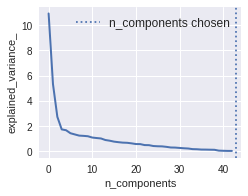

In [459]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X_digits = ext_data
y_digits = y_extension

# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 43]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()